# Improving retrieval in DB search for RAG

Dror Meirovich 

Information Theory and Language Models, Spring 2024

School of Computer Science

Reichman University


## Abstract

The RAG method uses a text-generative engine (such as GPT) to answer a query regarding a reference text we extracted earlier from a database. The main advantage of RAG is overcoming the LLM inconsistency and hallucinations by grounding the LLM into a corpus of facts. In this work, we introduce a statistical method, Higher Criticism, to improve the relevancy of the database's search results presented to the LLM model, resulting in better response.

## Introduction

### The meaning of RAG
1. Retrival Augmented - Searching documents in a database and selecting a subset that fits a given a query, usually in human language.<br>
2. Generation - Generating an answer for the query given the reference documents.

![title](https://i0.wp.com/gradientflow.com/wp-content/uploads/2023/10/newsletter87-RAG-simple.png)

### Applications:
1. Direct question answering from a corpus.<br>
2. Chatbots and Virtual Assistants which talks to the clients using a reference database.<br>
3. Content Creation: Generating content that requires factual accuracy, such as news articles or technical documentation.<br>

### Benefits of RAG
1. Improved Accuracy: By leveraging external information, RAG models can provide more accurate and fact-based responses.<br>
2. Context Awareness: The retrieval component allows the model to consider a broader context, leading to more relevant and informed outputs.<br>
3. Flexibility: RAG frameworks can be adapted to various domains by updating the retrieval corpus, making them versatile for different applications.<br>

### Text Embedding

Text embedding converts words or sentences into numerical vectors that capture their meanings and relationships. This transformation allows computers to understand and process language more effectively. By representing text as numbers, computers can perform tasks like translation, sentiment analysis, and search with better accuracy.<br>

Creating a text embedding of a sentence involves using an encoder LLM, such as BERT. The process begins by passing the sentence through the model, which generates hidden states for each token. From these hidden states, the final layer's hidden state of the last token is extracted. This hidden state, known as the embedding, encapsulates the context and meaning of the entire sentence.<br>
A different approach to calculating sentence embedding is calculating the mean of each sentence token's embedded vectors. However, it doesn't consider the order of the tokens, potentially resulting in a vector that doesn't accurately represent the entire sentence. This limitation highlights the need for more advanced techniques in text embedding.

In our work, we first convert our query and each text chunk from the database into embedding vectors. Later, we will calculate the similarity between the embedded query and the embedded texts to choose the most relevant ones. We use cosine similarity because the model already normalizes each embedding vector, and cosine similarity is inversely related to the angle between these vectors.

In [1]:
!pip install -U sentence-transformers

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  Using cached transformers-4.41.2-py3-none-any.whl.metadata (43 kB)
  Using cached huggingface_hub-0.23.4-py3-none-any.whl.metadata (12 kB)
  Using cached fsspec-2024.6.0-py3-none-any.whl.metadata (11 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 1.2 MB/s eta 0:00:00a 0:00:01
Using cached huggingface_hub-0.23.4-py3-none-any.whl (402 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 MB 7.3 MB/s eta 0:00:0000:0100:01m
Using cached transformers-4.41.2-py3-none-any.whl (9.1 MB)
Using cached fsspec-2024.6.0-py3-none-any.whl (176 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.3/416.3 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━

### Porting to Google Colab
The following cell enables this notebook to run from Google Colab as well as from your local machine IDE.<br>
You can change `root_directory` and/or `this_notebook_google_path` to point to the directory in your Google account, which contains this notebook, together with the `imgs` sub-directory and the rest of the files.<br>

In [2]:
import sys
import os
try:
    from google.colab import drive
    root_directory = '/content/gdrive/'
    this_notebook_google_path = root_directory + 'Othercomputers/My Laptop/projects/RUNI/seminar_info_theory'
    drive.mount(root_directory)
    # enable import python files from this notebook's path
    sys.path.append(this_notebook_google_path)
    # enable reading images and data files from this notebook's path
    os.chdir(this_notebook_google_path)
except:
    # no Google Colab --> fall back to local machine
    pass


### Playing with Sentence Transformer

In [3]:
# reference to sentence transformers: https://sbert.net/
# https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

from sentence_transformers import SentenceTransformer
import torch
import numpy as np

model_embd = SentenceTransformer("all-MiniLM-L6-v2")
answers = [
    "The weather is lovely today",
    "It is so sunny outside",
    "He drove to the stadium"
]
answers_embd = model_embd.encode(answers)
print(f'Embedding Answers shape: {answers_embd.shape}')
if isinstance(answers_embd, torch.Tensor):
    answers_embd_data = answers_embd.detach().cpu().numpy()
else:
    answers_embd_data = answers_embd
embeddings_norm = np.linalg.norm(answers_embd_data, axis=1)
print(f'Embedding norm: Min={embeddings_norm.min():.4f}  Max={embeddings_norm.max():.4f}')

queries = ['What is the weather now',
           'The weather now is',
           'What is the weather today',
           'The weather today is']
queries_embd = model_embd.encode(queries)
similarities = model_embd.similarity(queries_embd, answers_embd)
print(similarities)



ModuleNotFoundError: No module named 'sentence_transformers'

### Utility Functions

In [ ]:
import matplotlib.pyplot as plt
import math
import numpy as np
import torch
from tqdm import tqdm

def print_first_sentences(sentences: list[str], num_sentences_to_print: int = 20) -> None:
    print(f"First {num_sentences_to_print} sentences:")
    for i in range(min(num_sentences_to_print,len(sentences))):
        print(f"\nSentence {i+1}:\n{sentences[i]}")

def print_last_sentences(sentences: list[str], num_sentences_to_print: int = 20) -> None:
    print(f"Last {num_sentences_to_print} sentences:")
    num_sentences = len(sentences)
    for i in range(min(num_sentences_to_print,num_sentences)):
        print(f"\nLast sentence from the end {i+1} ({num_sentences-i}):\n{sentences[-i-1]}")

def show_histogram(data: np.ndarray | torch.Tensor, title: str) -> None:
    if isinstance(data, torch.Tensor):
        data = data.detach().cpu().numpy()
    if data.ndim == 2:
        for ind, row in enumerate(data):
            show_histogram(row, title + f' data row = {ind+1} of {data.shape[0]}')
        return
    num_data = data.size
    bins = int(math.sqrt(num_data))
    plt.hist(data.reshape(-1), bins=bins, edgecolor='black');
    plt.title(f'{title}\nCount={num_data} Min={data.min():4f} Max={data.max():4f}\nMean={data.mean():4f} STDev={data.std():4f}');
    plt.show();

def embbed_sentences(sentences: list[str], title: str, to_print: int = 0, show_embed_histogram: bool = False, ind_embedding_to_print: list[int] = []):
    print(f'Number of {title}: {len(sentences)}')
    sentences_lengthes = [len(sent) for sent in sentences]
    print(f'{title} length (characters): Minimal={min(sentences_lengthes)}  Maximal={max(sentences_lengthes)}')
    if to_print > 0:
        print_first_sentences(sentences, to_print)
        print_last_sentences(sentences, to_print)
    sentences_embd = []
    chunk_size = 10
    for ind_sentence in tqdm(range(0,len(sentences),chunk_size)):
        sentences_embd.append(model_embd.encode(sentences[ind_sentence:ind_sentence+chunk_size]))
    if isinstance(sentences_embd[0], torch.Tensor):
        sentences_embd = torch.cat(sentences_embd, dim=0)
    else:
        sentences_embd = np.vstack(sentences_embd)
    print(f'embeddings type: {type(sentences_embd)}  embeddings shape: {sentences_embd.shape}')
    if show_embed_histogram:
        show_histogram(sentences_embd.reshape(-1), 'Histogram of all Embedded Values')
    if ind_embedding_to_print:
        print(f"Print some sentences and their embeddings:")
        for i in ind_embedding_to_print:
            print(f"Sentence {i+1}: {sentences[i]}")
            print(f"Embedding {i+1}: {sentences_embd[i][:5]}\n")

    return sentences_embd

## Loading Bool Q Dataset

The Bool Q dataset from Google Research consists from four columns:<br>
1. question
2. titles
3. answers(bool)
4. passages

In [ ]:
# reference: https://paperswithcode.com/dataset/boolq
# reference: https://github.com/google-research-datasets/boolean-questions
# download menually into the currect directory the file from:
# 'https://storage.cloud.google.com/boolq/train.jsonl'

import json

file_name = 'train.jsonl'

# Initialize lists
BoolQ_questions = []
BoolQ_titles = []
BoolQ_answers = []
BoolQ_passages = []

if not os.path.isfile(file_name):
    assert False, f'The file {file_name} does not exists in currect directory: {os.getcwd()}'
# Read and parse the JSONL file
with open(file_name, 'r') as file:
    for line in file:
        item = json.loads(line)
        BoolQ_questions.append(item['question'])
        BoolQ_titles.append(item['title'])
        BoolQ_answers.append(item['answer'])
        BoolQ_passages.append(item['passage'])

# Now you have all the lists populated
print(f'Number of questions: {len(BoolQ_questions)}')
print(f'Number of titles: {len(BoolQ_titles)}')
print(f'Number of answers: {len(BoolQ_answers)}')
print(f'Number of passages: {len(BoolQ_passages)}')

print(BoolQ_questions[0])
print(BoolQ_titles[0])
print(BoolQ_answers[0])
print(BoolQ_passages[0])


Number of questions: 9427
Number of titles: 9427
Number of answers: 9427
Number of passages: 9427
do iran and afghanistan speak the same language
Persian language
True
Persian (/ˈpɜːrʒən, -ʃən/), also known by its endonym Farsi (فارسی fārsi (fɒːɾˈsiː) ( listen)), is one of the Western Iranian languages within the Indo-Iranian branch of the Indo-European language family. It is primarily spoken in Iran, Afghanistan (officially known as Dari since 1958), and Tajikistan (officially known as Tajiki since the Soviet era), and some other regions which historically were Persianate societies and considered part of Greater Iran. It is written in the Persian alphabet, a modified variant of the Arabic script, which itself evolved from the Aramaic alphabet.


### We will build the embedded vectors for each of the sentences.

Number of BoolQ Questions: 9427
BoolQ Questions length (characters): Minimal=20  Maximal=100


100%|██████████| 943/943 [01:56<00:00,  8.12it/s]


embeddings type: <class 'numpy.ndarray'>  embeddings shape: (9427, 384)


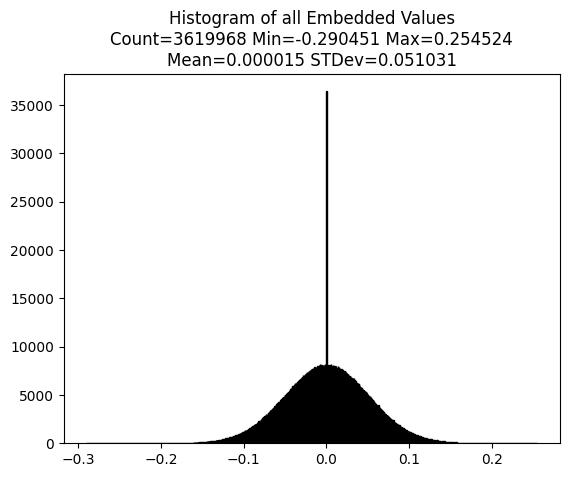

Number of BoolQ Titles: 9427
BoolQ Titles length (characters): Minimal=1  Maximal=78


100%|██████████| 943/943 [01:23<00:00, 11.26it/s]

embeddings type: <class 'numpy.ndarray'>  embeddings shape: (9427, 384)


In [ ]:
BoolQ_questions_embd = embbed_sentences(BoolQ_questions, title='BoolQ Questions', show_embed_histogram=True)
BoolQ_titles_embd = embbed_sentences(BoolQ_titles, title='BoolQ Titles', show_embed_histogram=False)
#BoolQ_passages_embd = embbed_sentences(BoolQ_passages, title='BoolQ Passages', show_embed_histogram=False)

### We will select 3 random queries and calculate their similarity score vs. all possible titles

Selected BoolQ queries:
Query [8264] = is k2 the highest mountain in the world


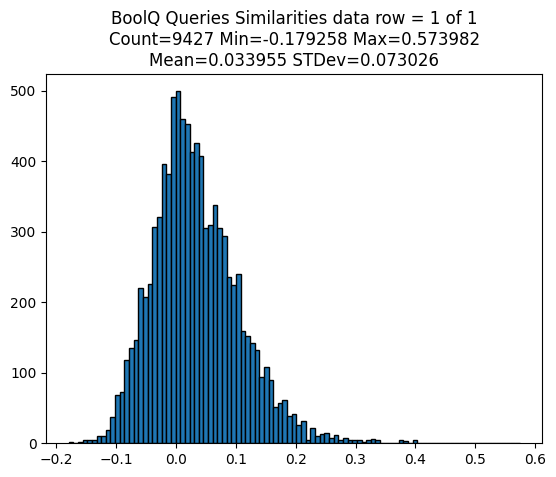

In [ ]:
num_queries = 1
BoolQ_indices = np.arange(BoolQ_questions_embd.shape[0])
np.random.shuffle(BoolQ_indices)
BoolQ_indices = BoolQ_indices[:num_queries]
BoolQ_queries = [BoolQ_questions[i] for i in BoolQ_indices]
print(f'Selected BoolQ queries:')
for ind, q in enumerate(BoolQ_queries):
    print(f'Query [{BoolQ_indices[ind]}] = {q}')

BoolQ_queries_embd = model_embd.encode(BoolQ_queries)
BoolQ_queries_similarities = model_embd.similarity(BoolQ_queries_embd, BoolQ_titles_embd)
show_histogram(BoolQ_queries_similarities, 'BoolQ Queries Similarities')

For each query we see a histogram of all its similarities scores vs. all embedding vectors of the titles in the Bool Q dataset.<br>
But which score is considered high enough to represent a meaningful answer for our query? How can we determine the threshold?<br>
Therefore, we want to convert the similarity score into P-Values for reporting the ones that are extreme.<br>

## Building general null hypothesis for similary

In [ ]:
import bisect
from typing import Union
import numbers

class Similarity_Null_Hypothesis:
    def __init__(self, name: str) -> None:
        self.name = name
        self.null_distribution = np.empty(shape=0)
        self.p_values = None
        self.p_arg_sort = None
        self.sorted_p_values = None
        self.num_discoveries = None
        self.selected_query = None
        self.reference_text = None

    def from_matrix(self, null_distribution: np.ndarray|torch.Tensor) -> None:
        if isinstance(null_distribution, torch.Tensor):
            null_distribution = null_distribution.detach().cpu().numpy()
        self.null_distribution = np.sort(null_distribution.astype(np.float32).reshape(-1))

    def show_histogram(self, title: str = '') -> None:
        if not title:
            title = f'Histogram of {self.name}'
        show_histogram(self.null_distribution, title)

    def create_p_values(self, similarities) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
        p_values = self.sf_many_queries(similarities)
        p_arg_sort = np.argsort(p_values, axis=1)
        assert p_values.shape == p_arg_sort.shape
        sorted_p_values = np.vstack([query_p[query_arg] for query_p, query_arg in zip(p_values,p_arg_sort)])
        for ind_query, query_sorted_p_value in enumerate(sorted_p_values):
            plt.scatter(np.arange(1,query_sorted_p_value.size+1), query_sorted_p_value, s=1.5);
            plt.title(f'P-Values according to {self.name} distribution for query {ind_query+1}');
            plt.ylabel('P-Value')
            plt.xlabel('Ordered P-Values')
            plt.show();
        self.p_values = p_values
        self.p_arg_sort = p_arg_sort
        self.sorted_p_values = sorted_p_values
        return p_values, p_arg_sort, sorted_p_values

    def sf_many_queries(self, similarities: np.ndarray) -> np.ndarray:
        if similarities.ndim < 2:
            return np.expand_dims(self.sf(similarities), axis=0)
        results = [self.sf(row) for row in similarities]
        return np.vstack(results)

    def sf(self, similarity_val: float|list[float]|np.ndarray):
        if isinstance(similarity_val, numbers.Number):
            similarity_val = np.array([similarity_val], dtype=np.float32)
        elif isinstance(similarity_val, list):
            similarity_val = np.array(similarity_val, dtype=np.float32)
        elif isinstance(similarity_val, torch.Tensor):
            similarity_val = similarity_val.detach().cpu().numpy().astype(np.float32)
        elif isinstance(similarity_val, np.ndarray):
            similarity_val = similarity_val.astype(np.float32)
        similarity_val = similarity_val.reshape(-1)
        results = np.empty(shape=len(similarity_val), dtype=np.float32)
        len_null = self.null_distribution.size
        for ind_val, val in enumerate(similarity_val):
            if val < self.null_distribution[0]:
                results[ind_val] = 1-1/len_null
            elif val > self.null_distribution[-1]:
                results[ind_val] = 1/len_null
            else:
                index  = bisect.bisect_left(self.null_distribution, np.float32(val))
                results[ind_val] = 1-index/len_null

        return results if results.size > 1 else results[0]

    def plot_HC(self, gamma: float = 0.1):
        N = self.sorted_p_values.shape[1]
        N_i = np.arange(1,N).astype(np.float32)/N
        nominators = N_i - self.sorted_p_values[:,:-1]
        denominators = np.sqrt(N_i*(1-N_i)).astype(np.float32)
        HC_objectives = math.sqrt(N)*nominators/denominators
        num_discoveries = np.argmax(HC_objectives[:,:int(gamma*N)], axis=1) + 1
        plt.rcParams["figure.figsize"] = (15,3)
        for ind_query, query_HC_objective in enumerate(HC_objectives):
            n_discoveries = num_discoveries[ind_query]
            plt.scatter(x=np.arange(1,query_HC_objective.size+1),y=query_HC_objective, s=1.5);
            plt.vlines(x=n_discoveries+0.5, ymin=query_HC_objective.min(), ymax=query_HC_objective.max(), color='red')
            plt.title(f'HC objective for query {ind_query+1}\ngamma={gamma:.2f} # Discoveries = {n_discoveries}');
            plt.ylabel('HC objective value')
            plt.xlabel('Ordered P-Values')
            #plt.xscale('log')
            plt.show();
        plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
        self.num_discoveries = num_discoveries
        return num_discoveries

    def collect_references(self, queries: list[str], references: list[str], num_max_references: int = 5):
        selected_query = []
        reference_text = []
        for ind_selected_query in range(self.num_discoveries.size):
            selected_query.append(queries[ind_selected_query])
            num_discoveries_in_selected_query = self.num_discoveries[ind_selected_query]
            if num_max_references > 0 and num_discoveries_in_selected_query > num_max_references:
                num_discoveries_in_selected_query = num_max_references
            ind_selected_embeddings = self.p_arg_sort[ind_selected_query][:num_discoveries_in_selected_query]
            assert np.unique(ind_selected_embeddings).size == ind_selected_embeddings.size
            reference_sentences = [references[ind] for ind in ind_selected_embeddings]
            print(f'For the selected query: {selected_query[-1]} some of the references are:')
            for i in range(min(10,len(reference_sentences))):
                if i > 0 and reference_sentences[i] == reference_sentences[i-1]:
                    for j in range(i+1):
                        print(ind_selected_embeddings[j], references[ind_selected_embeddings[j]], reference_sentences[j])
                    assert False
                print(f'Ref[{i+1}]:\n',reference_sentences[i])
            reference_text.append('\n'.join(reference_sentences))
        self.selected_query = selected_query
        self.reference_text = reference_text
        return selected_query, reference_text


# Building null distribution for random cosine similary

In [ ]:
class Cosine_Similarity_Null_Hypothesis(Similarity_Null_Hypothesis):
    def __init__(self, embedded_dim: int, num_embedded: int = 1000):
        super().__init__('Cosine Simililarity Null Hypothesis')
        random_data = np.random.randn(num_embedded, embedded_dim).astype(np.float32)
        random_data /= np.linalg.norm(random_data, axis=1, keepdims=True).astype(np.float32)
        self.from_matrix(random_data@random_data.T)
        # removing self similarities
        self.null_distribution = self.null_distribution[:-num_embedded]
        self.show_histogram()


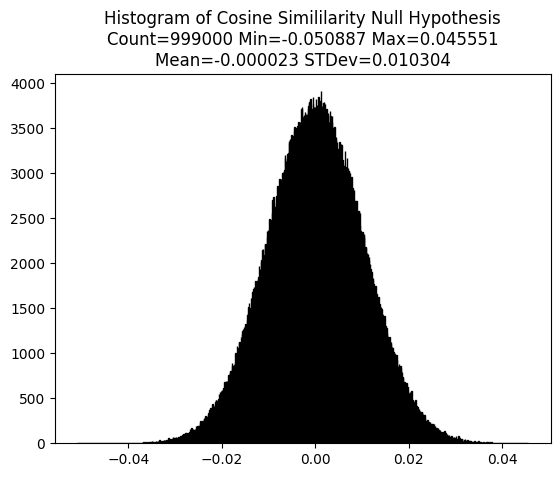

In [ ]:
cosine_similarity_distribution = Cosine_Similarity_Null_Hypothesis(BoolQ_queries_similarities.shape[1])

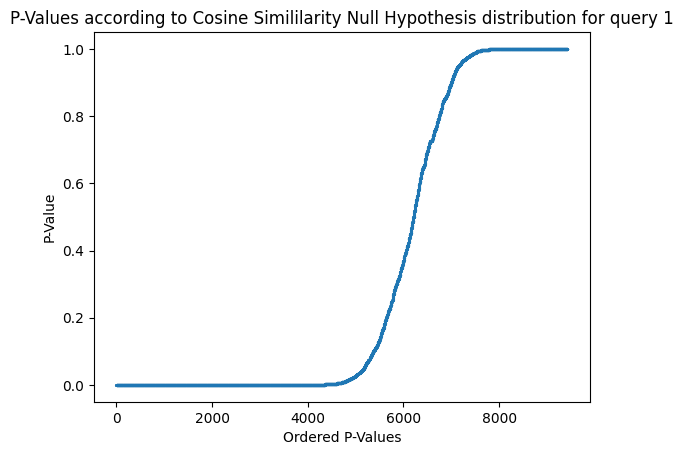

In [ ]:
cosine_similarity_distribution.create_p_values(BoolQ_queries_similarities);

# When comparing the similarities score to the global symetric cosine similarity distribution, we get bad results...
# This is due the fact that random cosine distribution does not represent the true distribution of real subset of the embedded vectors in a subspace of all possible vectors.
# When using random cosine similarity as a null distribution, most of the similarities are considered extreme, due to their low P-Value.

# Building null hypothesis for embedding similary

In [ ]:
class Embedded_Similarity_Null_Hypothesis(Similarity_Null_Hypothesis):
    def __init__(self, model, embedded_vectors, name: str, ratio: float = 0.25):
        super().__init__(name)
        if isinstance(embedded_vectors, list):
            embedded_vectors1, embedded_vectors2 = embedded_vectors[0], embedded_vectors[1]
        else:
            num_embedded = embedded_vectors.shape[0]
            group_size = int(num_embedded*min(ratio,0.5))
            indices = np.arange(num_embedded)
            np.random.shuffle(indices)
            embedded_vectors1 = embedded_vectors[indices[:group_size]]
            embedded_vectors2 = embedded_vectors[indices[-group_size:]]
        similarities = model_embd.similarity(embedded_vectors1, embedded_vectors2)
        self.from_matrix(similarities)
        self.show_histogram();


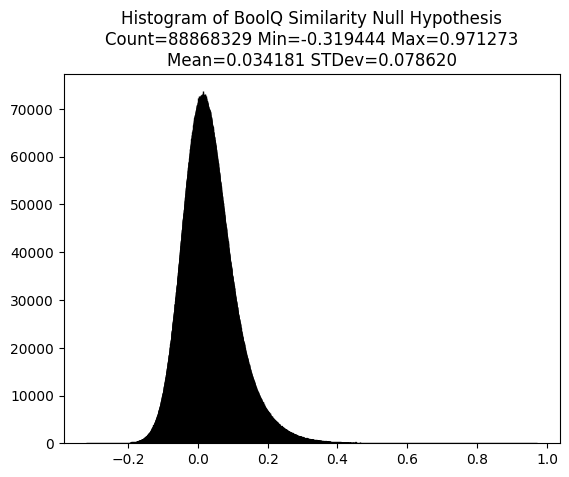

In [ ]:
BoolQ_similarity_distribution = Embedded_Similarity_Null_Hypothesis(model_embd, [BoolQ_questions_embd,BoolQ_titles_embd], 'BoolQ Similarity Null Hypothesis')

# Now, when we compare the similarities scores to the baseline similarity distribution of the Bool Q database, we get meaningfull results!

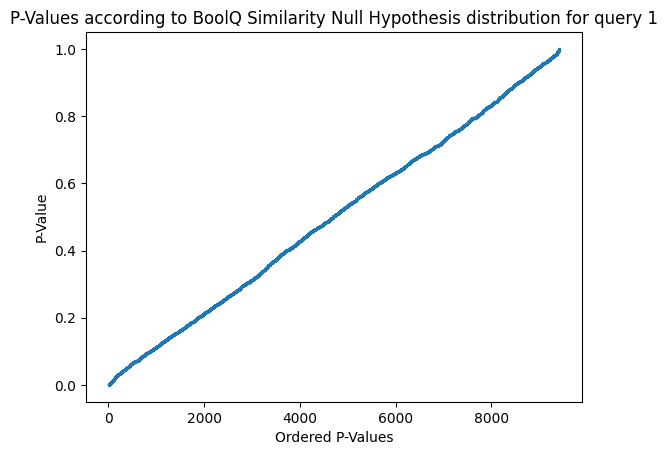

In [ ]:
BoolQ_similarity_distribution.create_p_values(BoolQ_queries_similarities);

# We will perform HC analysis on the P-Values
$$1\le i \le N-1$$
$$N_i:=\frac{i}{N}$$
$$HC=\underset{i}{max}\left(\sqrt{N}\frac{N_i-P_i}{\sqrt{N_i\left(1-N_i\right)}}\right)$$

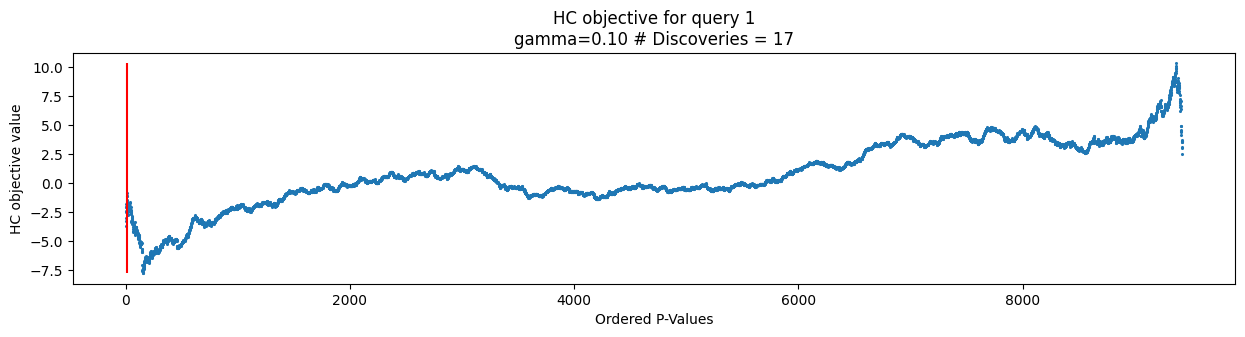

In [ ]:
BoolQ_similarity_distribution.plot_HC();

# Going to Generation of an answer...

In [ ]:
BoolQ_similarity_distribution.collect_references(BoolQ_queries, BoolQ_passages);

For the selected query: is k2 the highest mountain in the world some of the references are:
Ref[1]:
 K2 (Urdu: کے ٹو‬‎), also known as Mount Godwin-Austen or Chhogori (Balti and Urdu: چھوغوری‬‎), at 8,611 metres (28,251 ft) above sea level, is the second highest mountain in the world, after Mount Everest at 8,848 metres (29,029 ft). It is located on the China--Pakistan border between Baltistan in the Gilgit-Baltistan region of northern Pakistan, and the Taxkorgan Tajik Autonomous County of Xinjiang, China. K2 is the highest point of the Karakoram range and the highest point in both Pakistan and Xinjiang.
Ref[2]:
 Mount Kilimanjaro ( /ˌkɪlɪmənˈdʒɑːroʊ/), with its three volcanic cones, ``Kibo'', ``Mawenzi'', and ``Shira'', is a dormant volcano in Tanzania. It is the highest mountain in Africa, and rises approximately 4,900 metres (16,100 ft) from its base to 5,895 metres (19,341 ft) above sea level. The first persons known to have reached the summit of the mountain were Hans Meyer and Lu

### Prompt Engineering

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
ind_selected = 0
# Load the GPT-2 Small tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model_gpt2 = GPT2LMHeadModel.from_pretrained('gpt2')
reference_text = BoolQ_similarity_distribution.reference_text[ind_selected]
selected_query = BoolQ_similarity_distribution.selected_query[ind_selected]
prompt = f"Begin Reference Text: {reference_text}\n\nEnd of Reference Text.\n Based on the reference text, does {selected_query}?"
print(f'The prompt is:\n',prompt)
# Encode the input text and generate a response
inputs = tokenizer.encode(prompt, return_tensors='pt')

# Generate the response with memory optimization in mind
outputs = model_gpt2.generate(
    inputs,
    max_new_tokens=100,        #  Generate up to 100 new tokens
    num_return_sequences=1,    # Generate only one sequence to save memory
    temperature=0.7,           # Adjust temperature for randomness
    top_k=50,                  # Consider the top k tokens to reduce randomness
    top_p=0.9,                 # Use nucleus sampling
    pad_token_id=tokenizer.eos_token_id  # Set pad_token_id to eos_token_id
)

# Decode the response
response = tokenizer.decode(outputs[0], skip_special_tokens=True)
if response[:len(prompt)] == prompt:
    response = response[len(prompt):]
print(f'\n\nThe LLM response is:\n',response)
BoolQ_ind_answer = BoolQ_indices[ind_selected]
print(f'\nThe ground truth is: {BoolQ_answers[BoolQ_ind_answer]}')

The prompt is:
 Begin Reference Text: K2 (Urdu: کے ٹو‬‎), also known as Mount Godwin-Austen or Chhogori (Balti and Urdu: چھوغوری‬‎), at 8,611 metres (28,251 ft) above sea level, is the second highest mountain in the world, after Mount Everest at 8,848 metres (29,029 ft). It is located on the China--Pakistan border between Baltistan in the Gilgit-Baltistan region of northern Pakistan, and the Taxkorgan Tajik Autonomous County of Xinjiang, China. K2 is the highest point of the Karakoram range and the highest point in both Pakistan and Xinjiang.
Mount Kilimanjaro ( /ˌkɪlɪmənˈdʒɑːroʊ/), with its three volcanic cones, ``Kibo'', ``Mawenzi'', and ``Shira'', is a dormant volcano in Tanzania. It is the highest mountain in Africa, and rises approximately 4,900 metres (16,100 ft) from its base to 5,895 metres (19,341 ft) above sea level. The first persons known to have reached the summit of the mountain were Hans Meyer and Ludwig Purtscheller in 1889. The mountain is part of the Kilimanjaro Natio

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:520: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(




The LLM response is:
 

The answer is no. The highest mountain in the world is K2, which is the highest mountain in the world.

The highest mountain in the world is Mount Kilimanjaro, which is the highest mountain in the world.

The highest mountain in the world is Mount Kilimanjaro, which is the highest mountain in the world.

The highest mountain in the world is Mount Kilimanjaro, which is the highest mountain in the world.



The ground truth is: False


reference:<br>
1. https://research.ibm.com/blog/retrieval-augmented-generation-RAG
2. https://medium.com/enterprise-rag/an-introduction-to-rag-and-simple-complex-rag-9c3aa9bd017b
